# CNN Modelling // CIFAR dataset

### Import libraries and load dataset

In [23]:
#Data analysis
import pandas as pd
import numpy as np

#Data
from tensorflow.keras.datasets import cifar10

#Exclude warnings
import warnings
warnings.filterwarnings('ignore')

#Visualisations
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

#Modelling
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

#Evaluation
from sklearn.metrics import classification_report

#Saving models
import pickle
import os

In [25]:
#Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [26]:
#Limit data
n = 10000

train_images = train_images[:n]
train_labels = train_labels[:n]

### EDA

In [4]:
#Checking the labels
train_labels.shape

(10000, 1)

In [11]:
#Flattening labels for further inspection
flat_labels = train_labels.flatten()

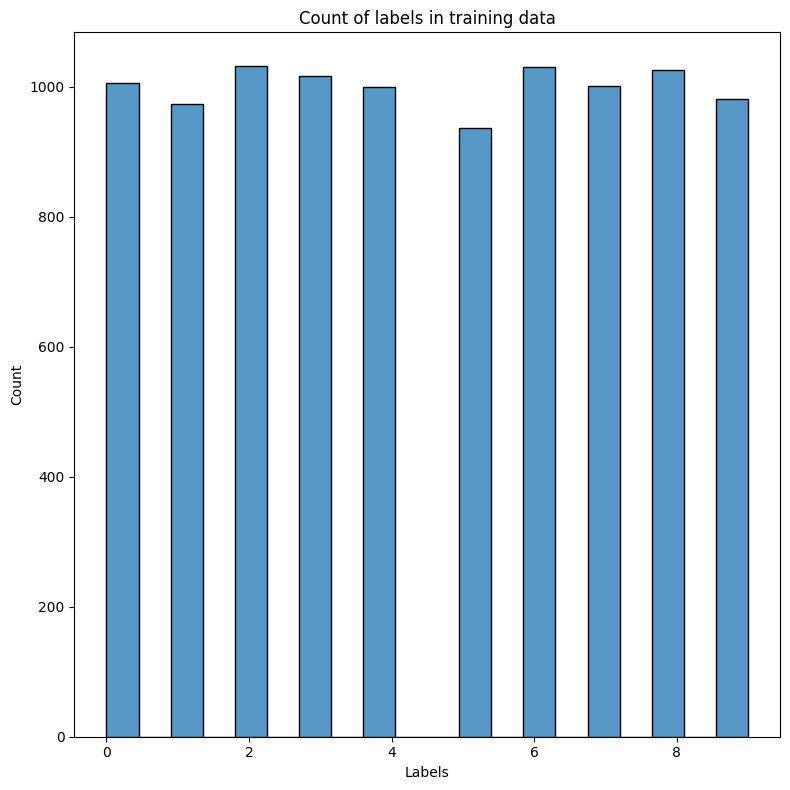

In [12]:
#Plotting labels to check distribution
figure(figsize=(8,8))
sns.histplot(x=flat_labels)
plt.title("Count of labels in training data")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The labels are almost equal. I will not worry about balancing them further.

In [29]:
#Checking train shape
train_images.shape

TensorShape([10000, 32, 32, 3])

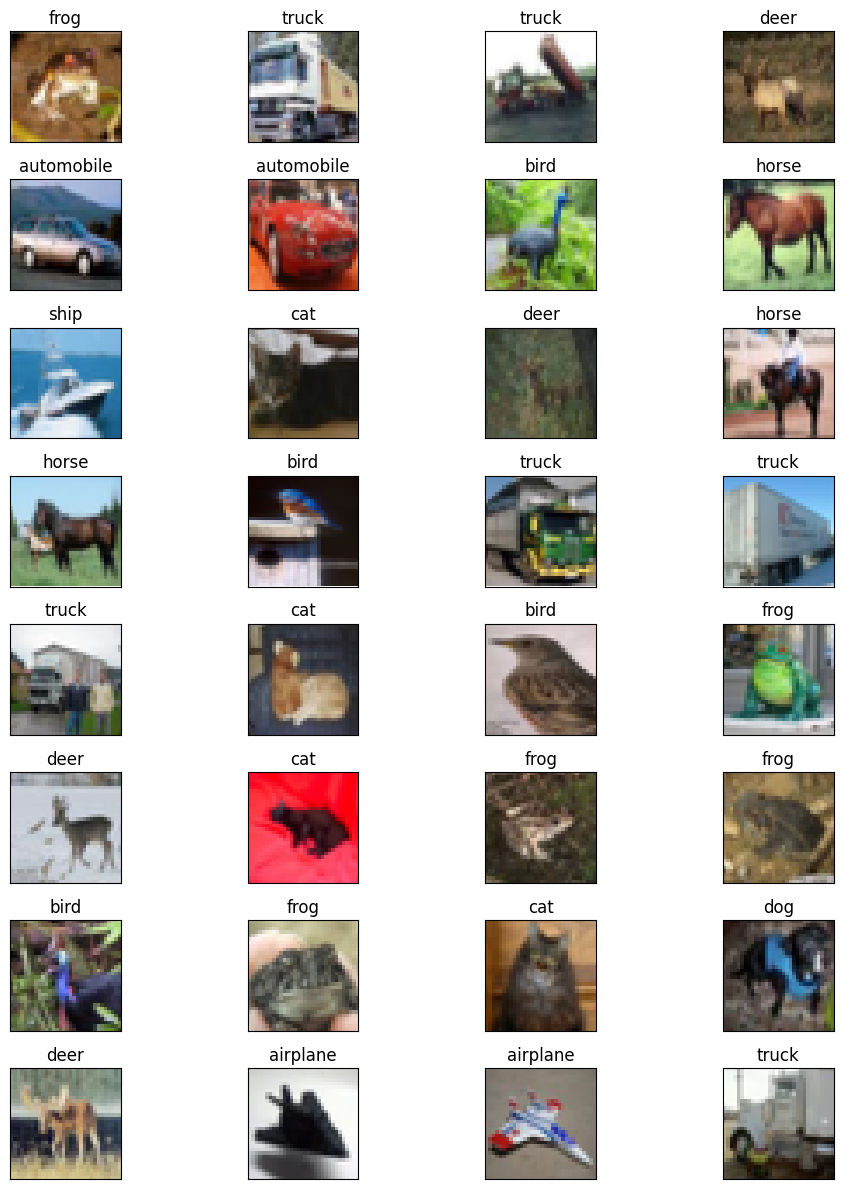

In [14]:
#Load image preview
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

plt.figure(figsize=(12,12))
for i in range(32):
    plt.subplot(8, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    label_index = int(train_labels[i])
    plt.title(class_names[label_index])
    plt.tight_layout()
plt.show()

### Preprocessing and modelling

In [27]:
#Normalize images
train_images = tf.cast(train_images, tf.float32) / 255.0
test_images = tf.cast(test_images, tf.float32) / 255.0

In [6]:
#Loading ResNet50 model
base_model = ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet'
)
#Freezing the base model to retain its pre-trained weights
base_model.trainable = False

In [17]:
#Creating a custom top layer
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [18]:
#Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
#Training the model
history = model.fit(
    train_images,
    train_labels,
    batch_size=32,
    validation_data=(test_images, test_labels),
    epochs=10,
    verbose = 1
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.1359 - loss: 2.2939 - val_accuracy: 0.2093 - val_loss: 2.1375
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.2344 - loss: 2.0747 - val_accuracy: 0.2656 - val_loss: 1.9665
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.2647 - loss: 1.9865 - val_accuracy: 0.2770 - val_loss: 1.9497
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.2865 - loss: 1.9391 - val_accuracy: 0.2928 - val_loss: 1.9676
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.3006 - loss: 1.9133 - val_accuracy: 0.3038 - val_loss: 1.9100
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.3056 - loss: 1.9034 - val_accuracy: 0.2971 - val_loss: 1.9089
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.3166 - loss: 1.8590 - val_accuracy: 0.3421 - val_loss: 1.8249
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.3305 - loss: 1.8449 - 

I will use this as a baseline. I will unfreeze the base model to find a more accurate solution. First, I will explore the results.

### Evaluation v1

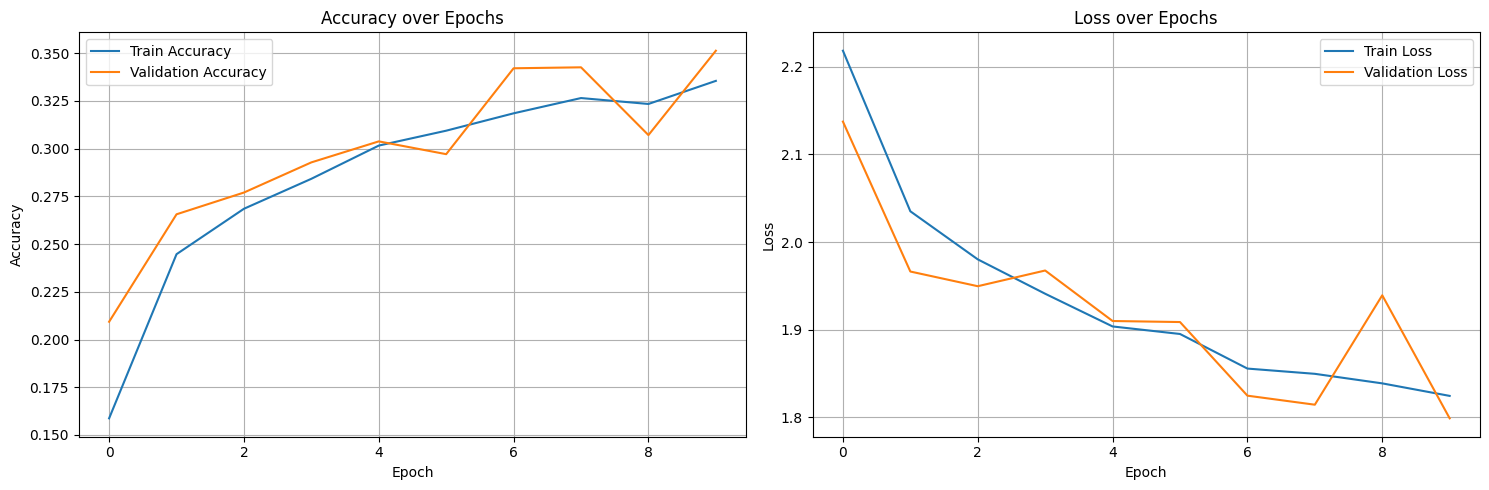

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

#plotting the loss and accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Accuracy over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

#Loss subplot
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

The model is showing a gradual improvement with validation beating the train data. At points the model appears slightly erratic, but this could be fixed by unfreezing the base model so that it can learn from the data.

In [23]:
#Evaluation
score = model.evaluate(test_images, test_labels, verbose=0)
print("test loss : {:.4f}" .format(score[0]))
print("accuracy : {:.4f}" .format(score[1]))

test loss : 1.7990
accuracy : 0.3513


In [24]:
#Building classification report
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_labels, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step
              precision    recall  f1-score   support

           0       0.50      0.31      0.38      1000
           1       0.38      0.47      0.42      1000
           2       0.28      0.27      0.27      1000
           3       0.18      0.14      0.16      1000
           4       0.38      0.16      0.23      1000
           5       0.33      0.38      0.35      1000
           6       0.27      0.55      0.36      1000
           7       0.40      0.39      0.40      1000
           8       0.46      0.48      0.47      1000
           9       0.45      0.37      0.40      1000

    accuracy                           0.35     10000
   macro avg       0.36      0.35      0.34     10000
weighted avg       0.36      0.35      0.34     10000



The classification report confirms that the model needs work. It is useful as a baseline.

In [33]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for i, class_name in enumerate(class_names):
    print(f"Label {i}: {class_name}")

Label 0: airplane
Label 1: automobile
Label 2: bird
Label 3: cat
Label 4: deer
Label 5: dog
Label 6: frog
Label 7: horse
Label 8: ship
Label 9: truck


The model is having most difficulty classifying cat, frog and automobile. I will work on an optimized version of the model to improve on these results.

In [34]:
#defining a location to save the model
pickle_dir = "/models"
model_filename = "modelv1.pkl"

#Constructing the full file path
pickle_path = os.path.join(pickle_dir, model_filename)

#Saving the model
with open(pickle_path, 'wb') as f:
    pickle.dump(model, f)

print(f"model saved as pickle file at: {pickle_path}")

model saved as pickle file at: /Users/dan/PycharmProjects/Masterschool/CV Project/models/modelv1.pkl


### Optimising model

In [ ]:
#Loading ResNet50 model (as v1)
base_model = ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet'
)

In [40]:
#Unfreezing baseline model
base_model.trainable = True

In [ ]:
#Creating a custom top layer (as v1)
modelv2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
#Adding an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [ ]:
#Compiling the model (as v1)
modelv2.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
#Training the model
history = modelv2.fit(
    train_images,
    train_labels,
    batch_size=32,
    validation_data=(test_images, test_labels),
    epochs=10,
    verbose = 1
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 114s 327ms/step - accuracy: 0.5887 - loss: 1.1594 - val_accuracy: 0.5778 - val_loss: 1.1747
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6895s 22s/step - accuracy: 0.6047 - loss: 1.1044 - val_accuracy: 0.5827 - val_loss: 1.1504
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 107s 341ms/step - accuracy: 0.6119 - loss: 1.0764 - val_accuracy: 0.5924 - val_loss: 1.1286
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 103s 330ms/step - accuracy: 0.6289 - loss: 1.0330 - val_accuracy: 0.5966 - val_loss: 1.1157
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 376ms/step - accuracy: 0.6229 - loss: 1.0482 - val_accuracy: 0.6023 - val_loss: 1.1049
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 106s 337ms/step - accuracy: 0.6252 - loss: 1.0390 - val_accuracy: 0.6068 - val_loss: 1.0899
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.6443 - loss: 0.9967 - val_accuracy: 0.6086 - val_loss: 1.0868
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 110s 352ms/step - accuracy: 0.6432 - los

### Evaluation v2

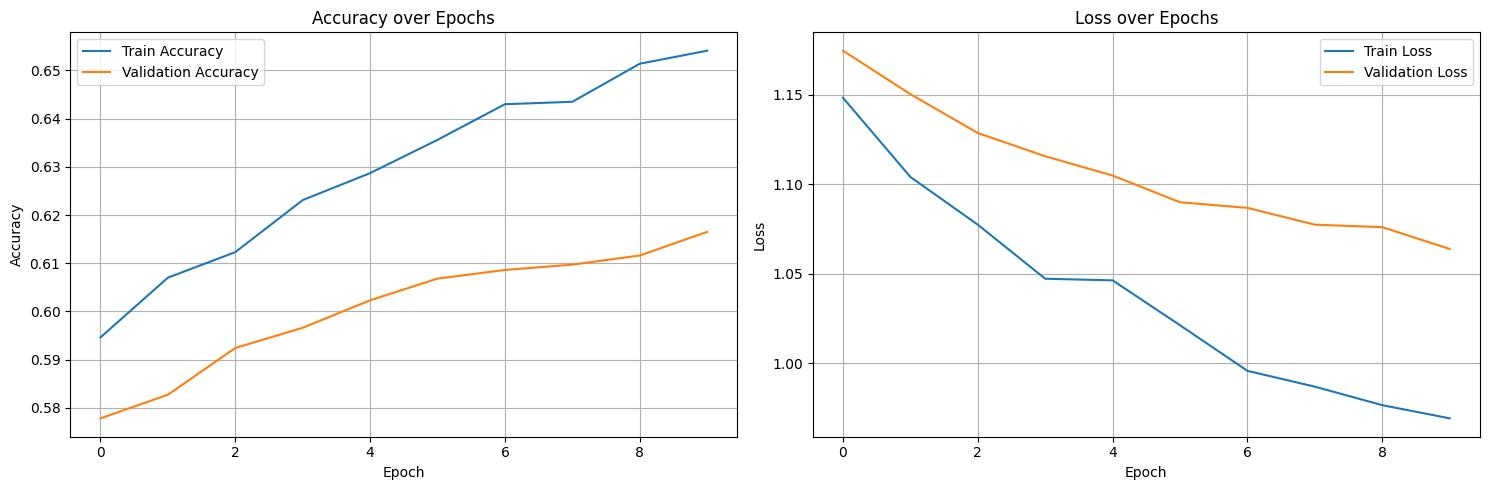

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

#plotting the loss and accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Accuracy over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

#Loss subplot
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

Train and validation are moving further apart as the model revisits the data suggesting signs of overfitting.

In [43]:
#Evaluation
score = modelv2.evaluate(test_images, test_labels, verbose=0)
print("test loss : {:.4f}" .format(score[0]))
print("accuracy : {:.4f}" .format(score[1]))

test loss : 1.0638
accuracy : 0.6165


Both metrics are demonstrating considerable improvement vs. the baseline model.

In [44]:
#Building classification report
y_pred = modelv2.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_labels, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step
              precision    recall  f1-score   support

           0       0.63      0.68      0.66      1000
           1       0.76      0.78      0.77      1000
           2       0.46      0.43      0.44      1000
           3       0.36      0.42      0.39      1000
           4       0.53      0.52      0.53      1000
           5       0.48      0.39      0.43      1000
           6       0.70      0.75      0.72      1000
           7       0.69      0.67      0.68      1000
           8       0.76      0.79      0.78      1000
           9       0.79      0.73      0.76      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



We are seeing much better performance in labels 6–9. One and six are much improved. Two and three are now the most challenging to correctly classify.

I will save the model and apply data augmentation to seek further improvements.

In [45]:
#Defining a location to save the model
pickle_dir = "/models"
model_filename = "modelv2.pkl"

#Constructing the full file path
pickle_path = os.path.join(pickle_dir, model_filename)

#Saving the model
with open(pickle_path, 'wb') as f:
    pickle.dump(modelv2, f)

print(f"model saved as pickle file at: {pickle_path}")

model saved as pickle file at: /Users/dan/PycharmProjects/Masterschool/CV Project/models/modelv2.pkl


### Data augmentation

In [104]:
#Loading ResNet50 model
base_model = ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet'
)

In [105]:
#Unfreezing baseline model (as v2)
base_model.trainable = True

In [106]:
#Implementing data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

In [107]:
#Defining inputs
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x) #as v2
x = tf.keras.layers.Dense(128, activation='relu')(x) #as v2
x = tf.keras.layers.Dense(10, activation='softmax')(x)

#Applying inputs and outputs to the model
modelv3 = tf.keras.Model(inputs=inputs, outputs=x)

In [108]:
#Keeping the optimizer (as v2)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [109]:
#Compiling the model (as v1 + v2)
modelv3.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [110]:
#Fitting the model (as v1 + v2)
history = modelv3.fit(
    train_images,
    train_labels,
    batch_size=32,
    validation_data=(test_images, test_labels),
    epochs=10,
    verbose=1
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 111s 322ms/step - accuracy: 0.1160 - loss: 2.7032 - val_accuracy: 0.1057 - val_loss: 61.9581
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 103s 329ms/step - accuracy: 0.1458 - loss: 2.3530 - val_accuracy: 0.0873 - val_loss: 36.2820
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 362ms/step - accuracy: 0.2103 - loss: 2.1633 - val_accuracy: 0.1790 - val_loss: 2.5656
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 377ms/step - accuracy: 0.2731 - loss: 2.0559 - val_accuracy: 0.3122 - val_loss: 2.0774
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.3265 - loss: 1.9414 - val_accuracy: 0.3642 - val_loss: 1.9144
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 122s 390ms/step - accuracy: 0.3790 - loss: 1.8177 - val_accuracy: 0.4034 - val_loss: 1.7600
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 409ms/step - accuracy: 0.4125 - loss: 1.6813 - val_accuracy: 0.4413 - val_loss: 1.6251
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 129s 411ms/step - accuracy: 0.4560

In [141]:
#Defining a location to save the model
pickle_dir = "/Users/dan/PycharmProjects/Masterschool/CV Project/models"
model_filename = "modelv3.pkl"

#Constructing the full file path
pickle_path = os.path.join(pickle_dir, model_filename)

#Saving the model
with open(pickle_path, 'wb') as f:
    pickle.dump(modelv3, f)

print(f"model saved as pickle file at: {pickle_path}")

model saved as pickle file at: /Users/dan/PycharmProjects/Masterschool/CV Project/models/modelv3.pkl


### Evaluation v3

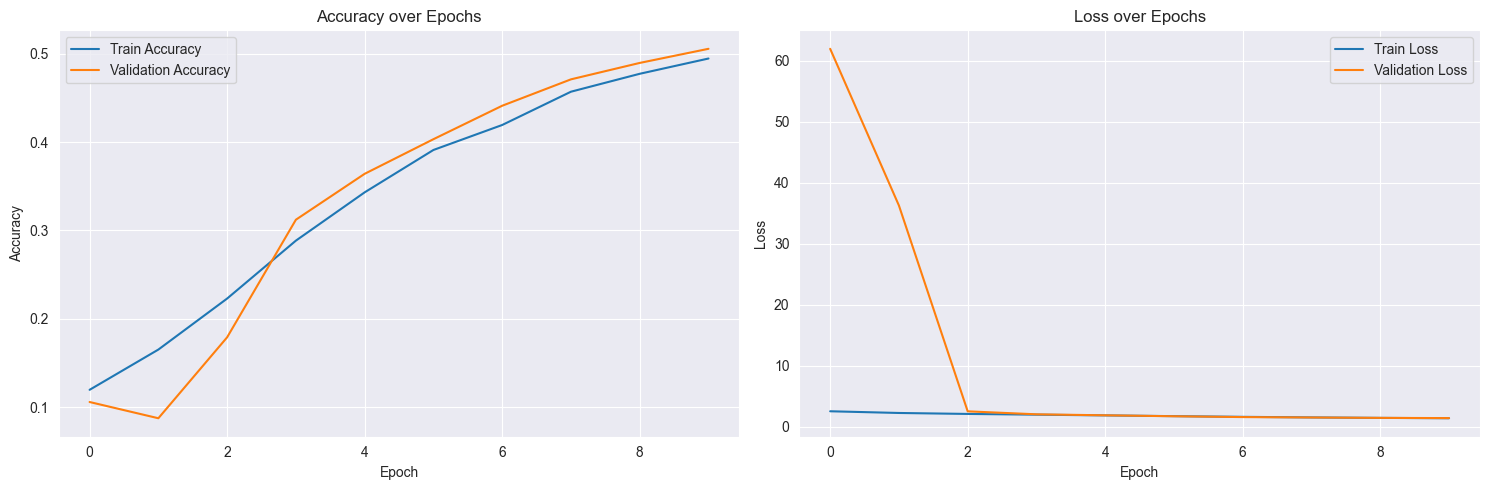

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

#plotting the loss and accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Accuracy over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

#Loss subplot
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

There no longer seems to be an overfitting problem with validation accuracy and train accuracy following the same upward trend from epoch 3.

The validation loss required two epochs before converging with the train loss.

In [113]:
#Evaluation
score = modelv3.evaluate(test_images, test_labels, verbose=0)
print("test loss : {:.4f}" .format(score[0]))
print("accuracy : {:.4f}" .format(score[1]))

test loss : 1.4572
accuracy : 0.5058


The overall accuracy and loss has declined from the previous model. However, there are no longer signs of overfitting.

In [114]:
#Classification report
y_pred = modelv3.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_labels, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      1000
           1       0.55      0.69      0.61      1000
           2       0.44      0.39      0.42      1000
           3       0.38      0.24      0.30      1000
           4       0.42      0.38      0.40      1000
           5       0.46      0.38      0.42      1000
           6       0.47      0.72      0.57      1000
           7       0.57      0.57      0.57      1000
           8       0.61      0.56      0.58      1000
           9       0.57      0.53      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000



The model is having difficulties defining classes 2–5.

In my final optimization, I will increase the number of epochs and apply early stopping to see if I can improve the accuracy, especially across classes 2–5.

### Final modelling

In [58]:
#Loading ResNet50 model (as prior versions)
base_model = ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet'
)

In [119]:
#Unfreeze base model (as v2 + v3)
base_model.trainable = True

In [120]:
#Implementing data augmentation (as v3)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

In [121]:
#Defining inputs
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs) #as v3
x = base_model(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x) #as previous
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x) #as previous
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

#Applying inputs and outputs to the model
modelv4 = tf.keras.Model(inputs=inputs, outputs=x)

In [122]:
#Adding optimiser (as v2 + v3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [123]:
#Adding early stopping
early_stopping = EarlyStopping(
    min_delta=0.0001,
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [124]:
#Compiling the model with the new optimizer
modelv4.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [125]:
#Fitting model
history = modelv4.fit(
    train_images,
    train_labels,
    batch_size=32,
    validation_data=(test_images, test_labels),
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 117s 339ms/step - accuracy: 0.1630 - loss: 2.3550 - val_accuracy: 0.3497 - val_loss: 1.8589
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 102s 326ms/step - accuracy: 0.3789 - loss: 1.7933 - val_accuracy: 0.4620 - val_loss: 1.5877
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 377ms/step - accuracy: 0.4593 - loss: 1.5794 - val_accuracy: 0.5044 - val_loss: 1.4659
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 121s 386ms/step - accuracy: 0.4978 - loss: 1.4747 - val_accuracy: 0.5347 - val_loss: 1.3827
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 123s 393ms/step - accuracy: 0.5291 - loss: 1.3914 - val_accuracy: 0.5530 - val_loss: 1.3288
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 402ms/step - accuracy: 0.5556 - loss: 1.3077 - val_accuracy: 0.5663 - val_loss: 1.2921
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 127s 406ms/step - accuracy: 0.5631 - loss: 1.2869 - val_accuracy: 0.5816 - val_loss: 1.2419
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 127s 406ms/step - accuracy: 0.5844 -

### Evaluation v4

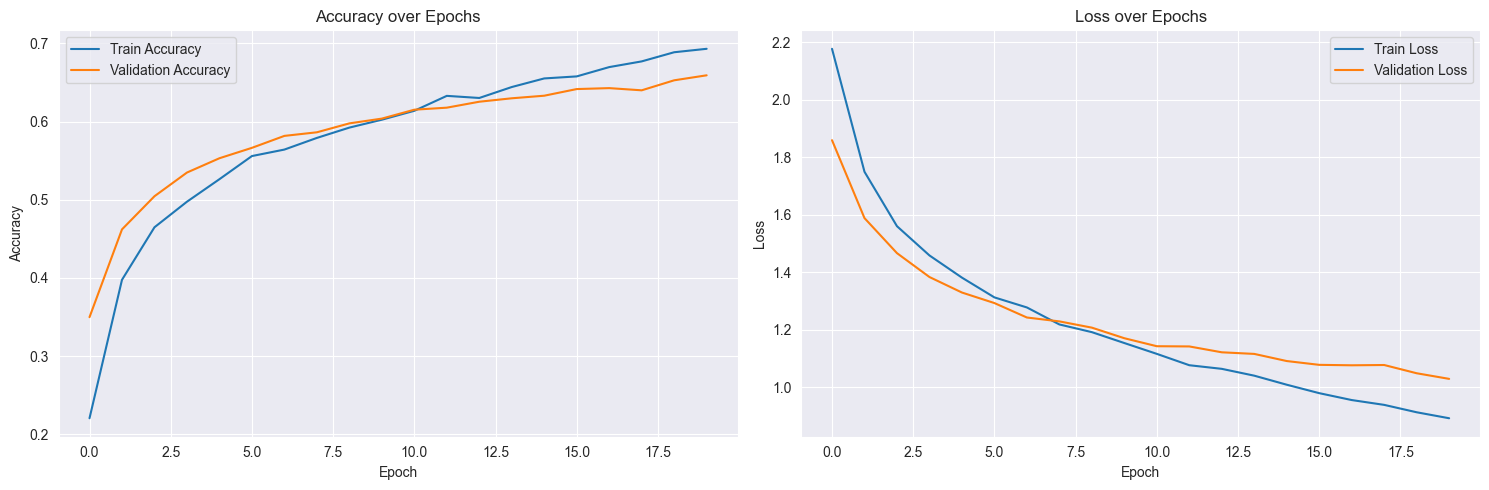

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

#plotting the loss and accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Accuracy over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

#Loss subplot
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [128]:
#Evaluation
score = modelv4.evaluate(test_images, test_labels, verbose=0)
print("test loss : {:.4f}" .format(score[0]))
print("accuracy : {:.4f}" .format(score[1]))

test loss : 1.0283
accuracy : 0.6591


In [129]:
#Classification report
y_pred = modelv4.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_labels, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step
              precision    recall  f1-score   support

           0       0.65      0.79      0.71      1000
           1       0.72      0.81      0.77      1000
           2       0.60      0.57      0.58      1000
           3       0.57      0.39      0.46      1000
           4       0.59      0.55      0.57      1000
           5       0.66      0.50      0.57      1000
           6       0.60      0.83      0.70      1000
           7       0.68      0.74      0.71      1000
           8       0.81      0.65      0.72      1000
           9       0.71      0.75      0.73      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.66      0.66      0.65     10000



In [140]:
#Defining a location to save the model
pickle_dir = "/Users/dan/PycharmProjects/Masterschool/CV Project/models"
model_filename = "modelv4.pkl"

#Constructing the full file path
pickle_path = os.path.join(pickle_dir, model_filename)

#Saving the model
with open(pickle_path, 'wb') as f:
    pickle.dump(modelv4, f)

print(f"model saved as pickle file at: {pickle_path}")

model saved as pickle file at: /Users/dan/PycharmProjects/Masterschool/CV Project/models/modelv4.pkl


### Testing model

In [130]:
result = modelv4.predict(test_images)
result = np.argmax(result,axis = 1)
result = pd.Series(result,name='Label')
result

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step


0       3
1       1
2       8
3       0
4       6
       ..
9995    0
9996    3
9997    5
9998    0
9999    7
Name: Label, Length: 10000, dtype: int64

In [143]:
#Checking the shape of results and labels
print("result shape:", result.shape)
print("test_labels shape:", test_labels.shape)

result shape: (10000,)
test_labels shape: (10000, 1)


In [144]:
#Flattening labels for testing and visualisation
test_labels = np.array(test_labels).flatten()

In [155]:
#Make sure test_labels is a numpy array
test_labels = np.array(test_labels)

#Create a DataFrame with predictions and ground truth
pred_df = pd.DataFrame({
    'Actual': test_labels,
    'Predicted': result
})

#Add index to track which image
pred_df['Index'] = pred_df.index

#Identify correct and incorrect predictions
correct_preds = pred_df[pred_df['Actual'] == pred_df['Predicted']]
wrong_preds = pred_df[pred_df['Actual'] != pred_df['Predicted']]
print(f"{wrong_preds.shape[0]} Incorrect out of 10,000")

3409 Incorrect out of 10,000


### Visualize predictions

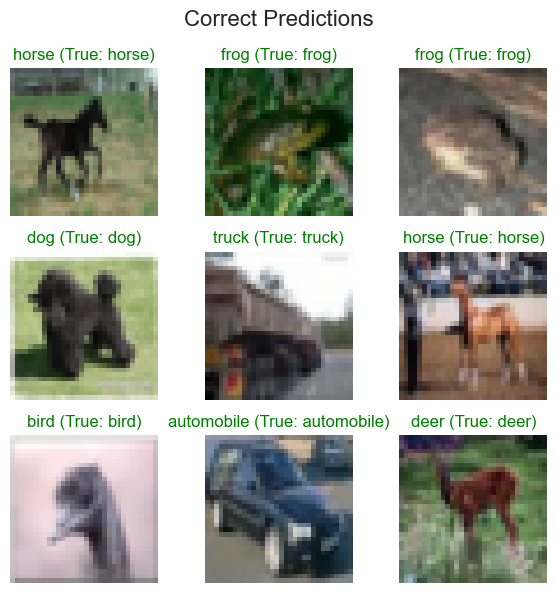

In [153]:
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# Pick random correct indices
sample_correct = correct_preds.sample(9)

plt.figure(figsize=(6, 6))
for i, idx in enumerate(sample_correct['Index']):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[idx])
    actual = class_names[test_labels[idx]]
    predicted = class_names[result[idx]]
    plt.title(f"{predicted} (True: {actual})", color='green')
    plt.axis('off')
plt.suptitle("Correct Predictions", fontsize=16)
plt.tight_layout()
plt.show()


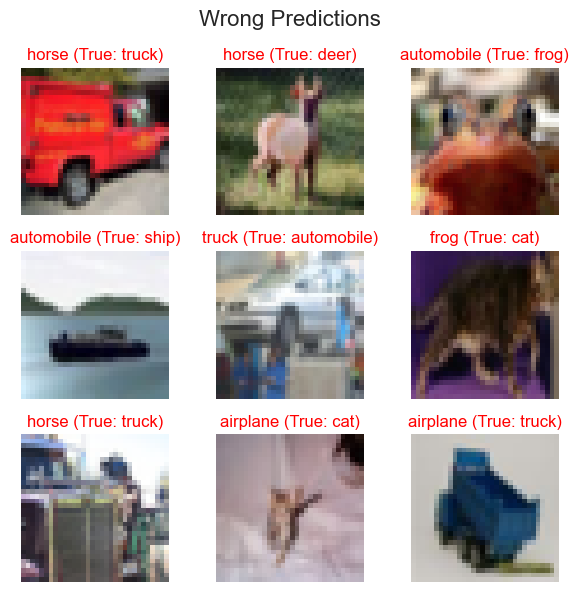

In [154]:
# Pick random incorrect indices
sample_wrong = wrong_preds.sample(9)

plt.figure(figsize=(6, 6))
for i, idx in enumerate(sample_wrong['Index']):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[idx])
    actual = class_names[test_labels[idx]]
    predicted = class_names[result[idx]]
    plt.title(f"{predicted} (True: {actual})", color='red')
    plt.axis('off')
plt.suptitle("Wrong Predictions", fontsize=16)
plt.tight_layout()
plt.show()
